# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [8]:
# # Intstall PyTorch and download data
# !pip3 install torch torchvision

# !wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

In [9]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [10]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [11]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [12]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [13]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [14]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [68]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None, scheduler_loss=False):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        if scheduler is not None:
            if scheduler_loss:
                scheduler.step(ave_loss)
            else:
                scheduler.step()
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        predictions = model(x_gpu)
        correct_samples += torch.sum(torch.argmax(predictions, 1) == y_gpu)
        total_samples += y.shape[0]
    
    return (correct_samples / total_samples).tolist()

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.288412, Train accuracy: 0.913439, Val accuracy: 0.891407
Average loss: 0.284548, Train accuracy: 0.913354, Val accuracy: 0.891885
Average loss: 0.282811, Train accuracy: 0.914394, Val accuracy: 0.897140
Average loss: 0.277517, Train accuracy: 0.916510, Val accuracy: 0.894000
Average loss: 0.282767, Train accuracy: 0.914292, Val accuracy: 0.896731


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [16]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./data/', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/data/study/mage/2_dl/dlcourse_ai/.venv/lib/python3.10/site-packages/torchvision/transforms/transforms.py:1292: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  warnings.warn(


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

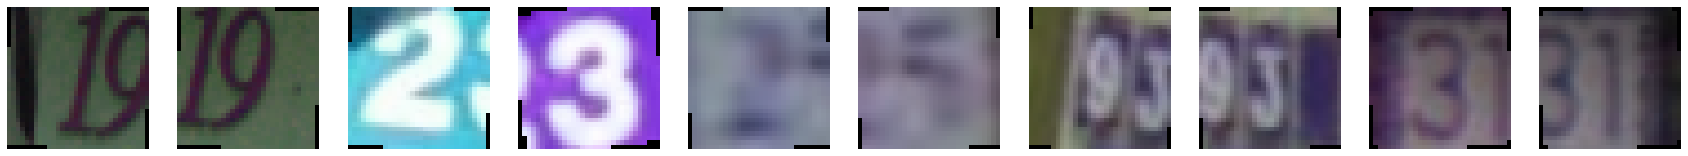

In [17]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./data/', 
                       transform=tfs
                      )

def show_data(dataset):
    plt.figure(figsize=(30, 3))

    for i, (x, y) in enumerate(dataset):
        if i == 10:
            break
        plt.subplot(1, 10, i+1)
        plt.grid(False)
        plt.imshow(x)
        plt.axis('off')

show_data(data_aug_vis)

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [18]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    # TODO: Add good augmentations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_aug = dset.SVHN('./data/', transform=tfs)

# TODO create new instances of loaders with the augmentations you chose
train_aug_loader = torch.utils.data.DataLoader(data_aug, batch_size=batch_size, sampler=train_sampler)

In [19]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.591176, Train accuracy: 0.820257, Val accuracy: 0.833663
Average loss: 0.550703, Train accuracy: 0.833618, Val accuracy: 0.842332
Average loss: 0.525873, Train accuracy: 0.839453, Val accuracy: 0.851955
Average loss: 0.514592, Train accuracy: 0.844350, Val accuracy: 0.826155
Average loss: 0.501095, Train accuracy: 0.847439, Val accuracy: 0.824108


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [24]:
def make_lenet():
    lenet_model = nn.Sequential(
        nn.Conv2d(3, 6, 5), # (32,32,3) -> (28, 28, 6)
        nn.Tanh(),
        nn.AvgPool2d(2, 2), #  (28, 28, 6) -> (14, 14, 6)

        nn.Conv2d(6, 16, 5), # (14, 14, 6) -> (10, 10, 16)
        nn.Tanh(),
        nn.AvgPool2d(2, 2), # (10, 10, 16) -> (5, 5, 16)

        Flattener(),

        nn.Linear(400, 120),
        nn.Tanh(),
        nn.Linear(120, 84),
        nn.Tanh(),
        nn.Linear(84, 10)
    )
    lenet_model.type(torch.cuda.FloatTensor)
    lenet_model.to(device)
    return lenet_model


In [23]:
# Let's train it!
lenet_model = make_lenet()
loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(lenet_model.parameters(), lr=1e-3, weight_decay=1e-3)

loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.546025, Train accuracy: 0.482544, Val accuracy: 0.793325
Average loss: 0.651673, Train accuracy: 0.802716, Val accuracy: 0.843901
Average loss: 0.535019, Train accuracy: 0.838685, Val accuracy: 0.853798
Average loss: 0.486022, Train accuracy: 0.851790, Val accuracy: 0.861989
Average loss: 0.454599, Train accuracy: 0.863154, Val accuracy: 0.871818
Average loss: 0.431596, Train accuracy: 0.868102, Val accuracy: 0.875708
Average loss: 0.414334, Train accuracy: 0.873699, Val accuracy: 0.871135
Average loss: 0.402403, Train accuracy: 0.877453, Val accuracy: 0.882943
Average loss: 0.392582, Train accuracy: 0.882043, Val accuracy: 0.882670
Average loss: 0.386598, Train accuracy: 0.882043, Val accuracy: 0.885810


# Подбор гиперпараметров

In [80]:
common_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])
])
train_transformations = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    common_transformations
])

def make_train_val_loaders(batch_size, train_samples):
    data_train = dset.SVHN('./data/', transform=train_transformations)
    data_val = dset.SVHN('./data/', transform=common_transformations)

    data_size = train_samples if train_samples is not None else data_train.data.shape[0]
    validation_split = .2
    split = int(np.floor(validation_split * data_size))
    indices = list(range(data_size))
    np.random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, sampler=val_sampler)
    return train_loader, val_loader

def make_test_loader(batch_size):
    data_test = dset.SVHN('./data/', split='test', transform=common_transformations)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
    return test_loader

/data/study/mage/2_dl/dlcourse_ai/.venv/lib/python3.10/site-packages/torchvision/transforms/transforms.py:1292: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  warnings.warn(


In [81]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_coef', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

def run(train_loader, val_loader, hp: Hyperparams, epochs: int) -> RunResult:
    lenet_model = make_lenet()
    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.Adam(lenet_model.parameters(), lr=hp.learning_rate, weight_decay=hp.reg)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=hp.anneal_epochs, gamma=hp.anneal_coef, verbose=True)

    history = train_model(lenet_model, train_loader, val_loader, loss, optimizer, epochs, scheduler=scheduler)
    loss_history, train_history, val_history = history
    return RunResult(lenet_model, train_history, val_history, val_history[-1])
    

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = (1, 5, 10, 15, 20, 50)
regs = [1e-3, 1e-4, 1e-5, 1e-7]
batch_size = 64

epoch_num = 10

train_loader, val_loader = make_train_val_loaders(batch_size, 20000)

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

for lr in learning_rates:
    for reg in regs:
        hp = Hyperparams(lr, anneal_coeff, anneal_epochs, reg)
        print(f"Checking hyperparameters: {hp}")
        res = run(train_loader, val_loader, hp, epoch_num)
        print(f"Final validation acuracy: {res.final_val_accuracy}")
        run_record[hp] = res

Checking hyperparameters: Hyperparams(learning_rate=0.1, anneal_coef=0.2, anneal_epochs=(1, 5, 10, 15, 20, 50), reg=0.001)
Adjusting learning rate of group 0 to 1.0000e-01.
Average loss: 2.807777, Train accuracy: 0.124125, Val accuracy: 0.120250
Adjusting learning rate of group 0 to 2.0000e-02.
Average loss: 2.357837, Train accuracy: 0.157688, Val accuracy: 0.125500
Adjusting learning rate of group 0 to 2.0000e-02.
Average loss: 2.341861, Train accuracy: 0.149750, Val accuracy: 0.141250
Adjusting learning rate of group 0 to 2.0000e-02.
Average loss: 2.327712, Train accuracy: 0.152250, Val accuracy: 0.152250
Adjusting learning rate of group 0 to 2.0000e-02.
Average loss: 2.319582, Train accuracy: 0.159188, Val accuracy: 0.168500
Adjusting learning rate of group 0 to 4.0000e-03.
Average loss: 2.261182, Train accuracy: 0.181000, Val accuracy: 0.190250
Adjusting learning rate of group 0 to 4.0000e-03.
Average loss: 2.240243, Train accuracy: 0.193625, Val accuracy: 0.250250
Adjusting learni

In [82]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
# Научим на всех данных
train_loader, val_loader = make_train_val_loaders(batch_size, None)
best_run = run(train_loader, val_loader, best_hyperparams, epoch_num)
best_val_accuracy = best_run.final_val_accuracy

print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

Adjusting learning rate of group 0 to 1.0000e-02.
Average loss: 1.812261, Train accuracy: 0.364792, Val accuracy: 0.686506
Adjusting learning rate of group 0 to 2.0000e-03.
Average loss: 0.751535, Train accuracy: 0.768914, Val accuracy: 0.820285
Adjusting learning rate of group 0 to 2.0000e-03.
Average loss: 0.590890, Train accuracy: 0.820547, Val accuracy: 0.845198
Adjusting learning rate of group 0 to 2.0000e-03.
Average loss: 0.522180, Train accuracy: 0.842098, Val accuracy: 0.849362
Adjusting learning rate of group 0 to 2.0000e-03.
Average loss: 0.491147, Train accuracy: 0.850715, Val accuracy: 0.864719
Adjusting learning rate of group 0 to 4.0000e-04.
Average loss: 0.378571, Train accuracy: 0.888220, Val accuracy: 0.892635
Adjusting learning rate of group 0 to 4.0000e-04.
Average loss: 0.353638, Train accuracy: 0.897383, Val accuracy: 0.896935
Adjusting learning rate of group 0 to 4.0000e-04.
Average loss: 0.343267, Train accuracy: 0.899430, Val accuracy: 0.897550
Adjusting learni

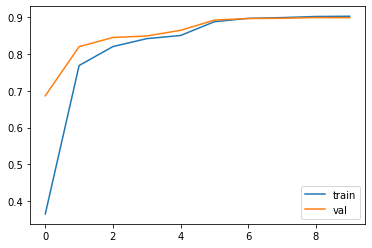

In [83]:
plt.plot(best_run.train_history, label="train")
plt.plot(best_run.val_history, label="val")
plt.legend()
plt.show()

# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [87]:
batch_size = 64
num_epochs = 10
train_loader, val_loader = make_train_val_loaders(batch_size, None)

nn_model = nn.Sequential(
    # 32*32*3
    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5),
    nn.BatchNorm2d(num_features=8),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(inplace=True),
    # 14*14*8
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=2),
    nn.BatchNorm2d(num_features=16),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
    nn.BatchNorm2d(num_features=32),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(inplace=True),
    # 7*7*32
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.BatchNorm2d(num_features=64),
    nn.ReLU(inplace=True),
    # 5*5*64
    Flattener(),
    nn.Linear(5*5*64, 320),
    nn.BatchNorm1d(num_features=320),
    nn.ReLU(),
    nn.Linear(320, 64),
    nn.BatchNorm1d(num_features=64),
    nn.ReLU(),
    nn.Linear(64, 10)

    # nn.Conv2d(3, 2, 5, padding=2),
    # nn.ReLU(),
    # nn.Conv2d(2, 6, 5), # (32,32,1) -> (28, 28, 6)
    # nn.ReLU(),
    # nn.AvgPool2d(2, 2), #  (28, 28, 6) -> (14, 14, 6)

    # nn.Conv2d(6, 16, 5), # (14, 14, 6) -> (10, 10, 16)
    # nn.ReLU(),
    # nn.AvgPool2d(2, 2), # (10, 10, 16) -> (5, 5, 16)

    # Flattener(),

    # nn.Linear(400, 120),
    # nn.ReLU(),
    # nn.Linear(120, 84),
    # nn.ReLU(),
    # nn.Linear(84, 10)
)
nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.2, step_size=4, verbose=True)

_, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler)

Adjusting learning rate of group 0 to 1.0000e-03.
Average loss: 0.640902, Train accuracy: 0.802085, Val accuracy: 0.889427
Adjusting learning rate of group 0 to 1.0000e-03.
Average loss: 0.378558, Train accuracy: 0.884073, Val accuracy: 0.902942
Adjusting learning rate of group 0 to 1.0000e-03.
Average loss: 0.336831, Train accuracy: 0.897536, Val accuracy: 0.906901
Adjusting learning rate of group 0 to 1.0000e-03.
Average loss: 0.312451, Train accuracy: 0.906221, Val accuracy: 0.914204
Adjusting learning rate of group 0 to 2.0000e-04.
Average loss: 0.218185, Train accuracy: 0.937617, Val accuracy: 0.933929
Adjusting learning rate of group 0 to 2.0000e-04.
Average loss: 0.187332, Train accuracy: 0.946354, Val accuracy: 0.937342
Adjusting learning rate of group 0 to 2.0000e-04.
Average loss: 0.167450, Train accuracy: 0.952240, Val accuracy: 0.936455
Adjusting learning rate of group 0 to 2.0000e-04.
Average loss: 0.152490, Train accuracy: 0.957274, Val accuracy: 0.936114
Adjusting learni

Final validation accuracy: 0.9400040507316589


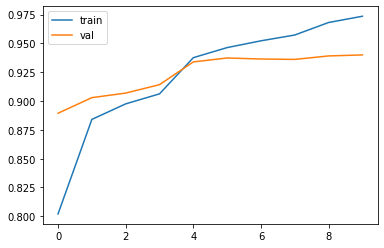

In [88]:
print(f"Final validation accuracy: {val_history[-1]}")
plt.plot(train_history, label="train")
plt.plot(val_history, label="val")
plt.legend()
plt.show()

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [89]:
test_loader = make_test_loader(batch_size)
final_test_accuracy = compute_accuracy(nn_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9416103363037109
